In [1]:
from blitz_env.simulate_draft_sqlite import simulate_draft, visualize_draft_board
from blitz_env.models import DatabaseManager, Player

def draft_player() -> str:
    db = DatabaseManager()
    try:
        # First, try to get the best available QB
        best_qb = db.session.query(Player).filter(
            Player.availability == 'AVAILABLE',
            Player.allowed_positions.contains("QB"),
        ).order_by(Player.rank).first()
        
        if best_qb:
            return best_qb.id
        
        # If no QBs available, get best overall player
        best_player = db.session.query(Player).filter(
            Player.availability == 'AVAILABLE'
        ).order_by(Player.rank).first()
        
        return best_player.id if best_player else ""
    finally:
        db.close()

# Run the draft simulation - data is stored in SQLite database
simulate_draft(draft_player, 2025)

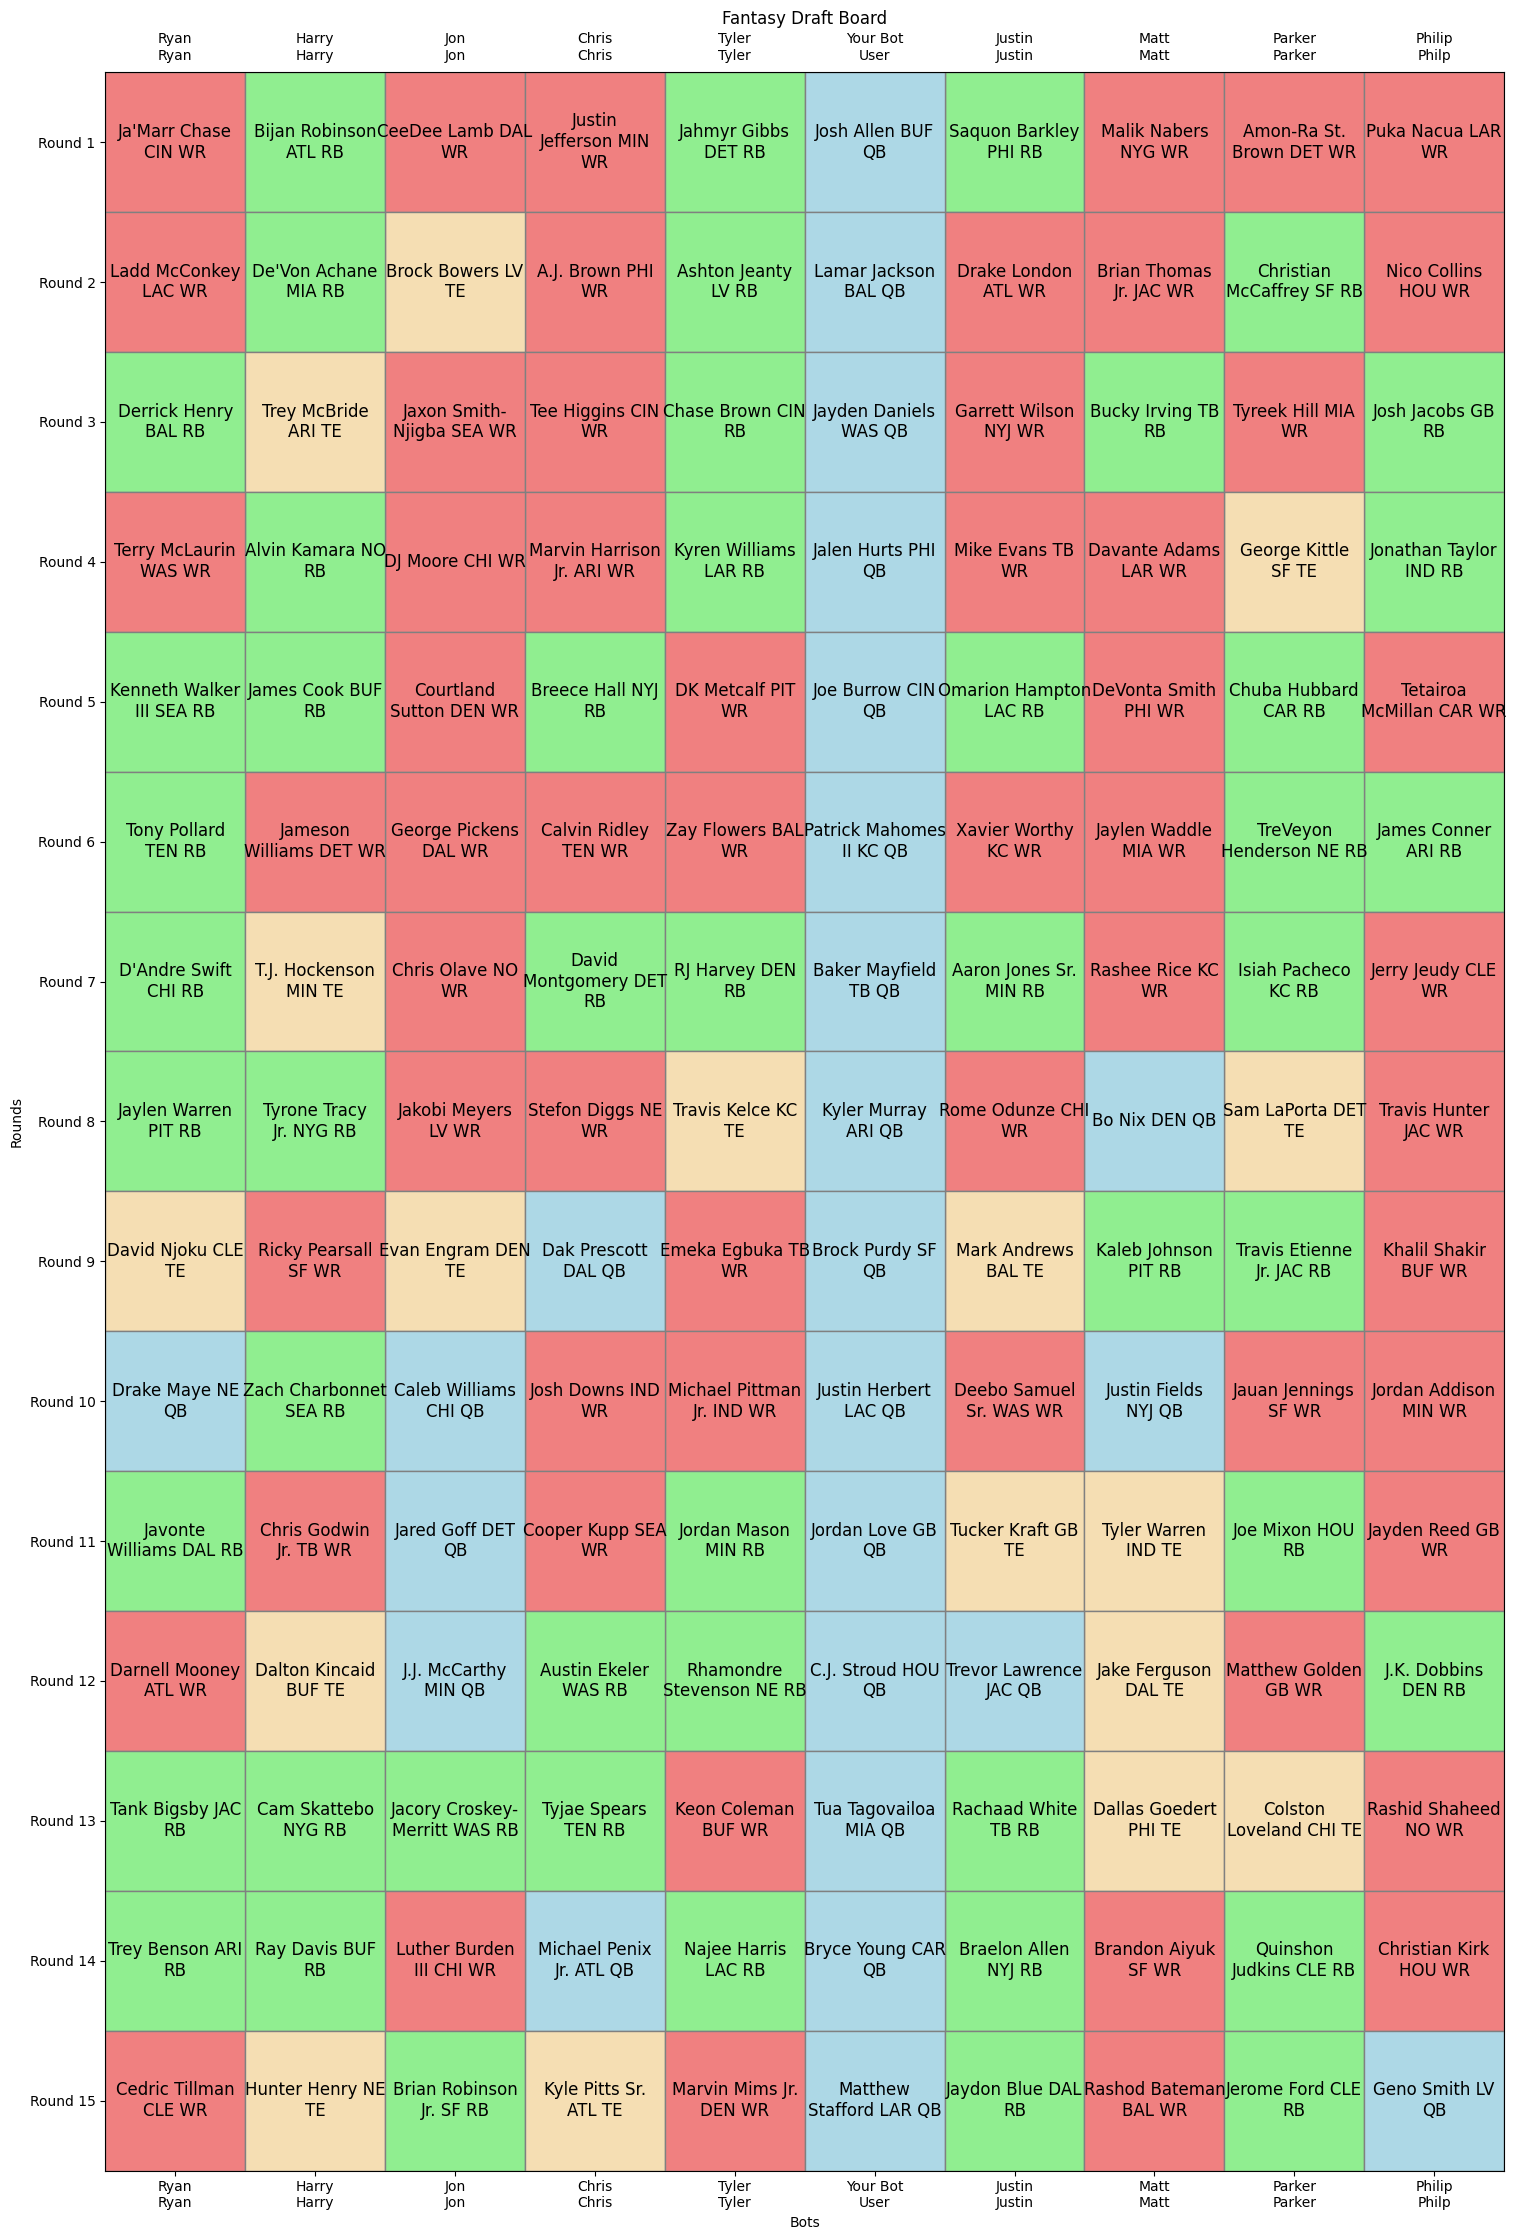

In [2]:
visualize_draft_board()